In [1]:
# kerasというpythonパッケージからCIFAR10というデータセットを読み込むためのモジュールをインポート
from keras.datasets import cifar10
# モジュールcifar10のload_data関数を実行して訓練データとテストデータを取得する
(train_X, train_y), (test_X, test_y) = cifar10.load_data()

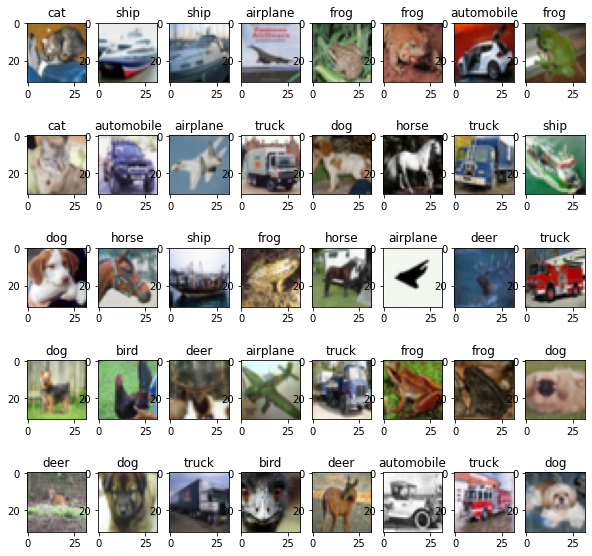

In [2]:
# matplotlibをセルの間に生じさせるための設定
%matplotlib inline
import matplotlib.pyplot as plt # matplotlibからpltモジュールをインポート
from PIL import Image # PLIからImageモジュールをインポート

fig = plt.figure(figsize=(10, 10)) # 10*10の画像表示域の確保

# CIFIR-10では下記の10種類の画像があり、それぞれ0〜9の数字で表される
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
          'dog', 'frog', 'horse', 'ship', 'truck']

# テストデータの中の先頭40画像とそれに写る物体名の表示
for i in range(40):
  im = Image.fromarray(test_X[i]) # 表示用の変換
  ax = fig.add_subplot(5, 8, i+1) # 5行8列のうちi+1番目のマスを選択
  ax.set_title(labels[test_y[i][0]]) # マスにタイトルを設定、各画像に写る物体はtest_yに含まれる
  ax.imshow(im) #画像をマスに表示

In [3]:
train_X[0] # 訓練データ中の1つ目の画像を確認する．なお，セル中の最後の行の出力は自動的に表示される

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

In [4]:
train_X[0].shape # 配列のサイズを確認する

(32, 32, 3)

In [5]:
train_X[0][0, 0] # 1行1列目の色を確認する

array([59, 62, 63], dtype=uint8)

In [6]:
train_X[0][0, 1] # 1行2列目の色を確認する

array([43, 46, 45], dtype=uint8)

In [7]:
train_y[0] #訓練データの1つ目の画像に何が写っているのかを確認する（6はfrog）

array([6], dtype=uint8)

In [8]:
# 画像に対する前処理
import numpy as np

#[行、列、RGB]となっていたデータ構造を[RGB, 行, 列]となるように変換
train_X = np.moveaxis(train_X, [3, 1, 2], [1, 2, 3]).astype('float32')
test_X = np.moveaxis(test_X, [3, 1, 2], [1, 2, 3]).astype('float32')

# 色が0~255で表されていたがこれが[0, 1]になるように変換する。（特徴量の正規化といって機械学習でよく用いられる）
train_X /= 255
test_X /= 255

# 画像に何が写っているかは上記の[6]のように1次元ベクトルで表現されてしまっていた。これを6のように単にスカラーで表現し直す
train_y = train_y.reshape(-1).astype('long')
test_y = test_y.reshape(-1).astype('long')

In [9]:
# PyTorchという深層学習用のパッケージで扱いやすい形式に変換
import torch
import torch.utils.data as data

batch_size = 128

# PyTorchのTensor型のデータに変換し，DataLoaderを利用して`batch_size`個ごとにデータを取り出せるように加工
ds_train = data.TensorDataset(torch.from_numpy(train_X), torch.from_numpy(train_y))
ds_test  = data.TensorDataset(torch.from_numpy(test_X),  torch.from_numpy(test_y))
dataloader_train = data.DataLoader(dataset=ds_train, batch_size=batch_size, shuffle=True)
dataloader_test  = data.DataLoader(dataset=ds_test,  batch_size=batch_size, shuffle=False)

In [10]:
# 分類用深層学習モデルの定義

import torch.nn as nn
import torch.nn.functional as F

class ImageClassifier(nn.Module):
    def __init__(self):
        super(ImageClassifier, self).__init__()
        self.conv11 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv12 = nn.Conv2d(32, 32, 3, padding=1)

        self.conv21 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv22 = nn.Conv2d(64, 64, 3, padding=1)

        self.fc1 = nn.Linear(64*8*8, 512)
        self.fc2 = nn.Linear(512, 10)

        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.25)
        self.dropout3 = nn.Dropout2d(0.5)


    def forward(self, x):
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        x = F.max_pool2d(x, (2, 2))
        x = self.dropout1(x)

        x = F.relu(self.conv21(x))
        x = F.relu(self.conv22(x))
        x = F.max_pool2d(x, (2, 2))
        x = self.dropout2(x)

        x = x.view(-1, 64*8*8)

        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        
        return self.fc2(x)

In [11]:
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

# 深層学習用の設定
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImageClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epoch_num = 1

for epoch in range(epoch_num):

    # 訓練データによる学習
    model.train()
    for batch_idx, (data, target) in enumerate(dataloader_train):
        # 全データから128個ずつデータを取得して学習していく
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data) # モデルに128個の画像を入力
        loss = criterion(output, target) # 正解との誤差を測定
        loss.backward() # 誤差が小さくなるようにパラメータ更新
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(dataloader_train.dataset),
                100. * batch_idx / len(dataloader_train), loss.item()))
    
    # テストデータによる評価
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in dataloader_test:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True) # 予測された物体を取得
            correct += pred.eq(target.view_as(pred)).sum().item() # 予測が当たっていた画像の数を取得
    test_loss /= len(dataloader_test.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(dataloader_test.dataset),
        100. * correct / len(dataloader_test.dataset)))

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.302230
Train Epoch: 0 [12800/50000 (26%)]	Loss: 1.980699
Train Epoch: 0 [25600/50000 (51%)]	Loss: 1.660587
Train Epoch: 0 [38400/50000 (77%)]	Loss: 1.594025

Test set: Average loss: -1.8870, Accuracy: 5077/10000 (51%)



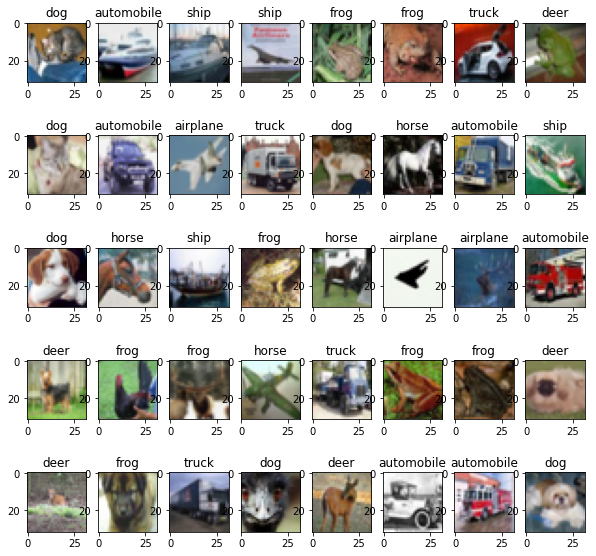

In [12]:
# 予測結果の表示
original_test_X = np.moveaxis(test_X, [2, 3, 1], [1, 2, 3])
original_test_X = original_test_X * 255
original_test_X = original_test_X.astype('uint8')

model.eval()
with torch.no_grad():
  for data, target in dataloader_test:
    data, target = data.to(device), target.to(device)
    output = model(data)
    pred = output.argmax(dim=1, keepdim=True) # 予測された物体の取得

    fig = plt.figure(figsize=(10, 10)) # 10*10の画像表示領域の確保

    # テストデータの中の先頭40画像とそれに写る物体名を表示
    for i in range(40):
      im = Image.fromarray(original_test_X[i]) # 表示用の変換
      ax = fig.add_subplot(5, 8, i+1) # 5行8列のうちi+1番目のマスを選択
      ax.set_title(labels[pred[i]]) # マスにタイトルを設定、各画像に写る物体はtest_yに含まれる
      ax.imshow(im) #画像をマスに表示
    break

In [13]:
!pip install janome

In [14]:
import requests

url = "https://drive.google.com/uc?export=download&id=1V3NtKvUy8BR8g4FxWHzvEPzNASjllgKh"
res = requests.get(url) # 上記URLからデータをダウンロード
tweets = res.json() # JSON形式として読み込む

# tweetsには辞書の配列が入っており，各辞書には以下のような情報が含まれている
# {
#   "label": [0, 0, 1, 0, 0],
#   "text":  "ツイート本文",
#   ...
# }

In [15]:
from janome.tokenizer import Tokenizer # janomeからTokenizerクラスをimportする

tokenizer = Tokenizer(wakati=True) # Tokenizerクラスのインスタンスを生成

# 前処理
tweets = [t for t in tweets if t["text"]] # 空ツイートを削除
X, y = [], []
for tweet in tweets:
    label = tweet["label"]
    target = label[1] # 2番目の値が1なら肯定的，0なら否定的，となるように加工済み
    text = tweet["text"]
    tokens = tokenizer.tokenize(text) # 文を単語（形態素）ごとに分割する
    tokens = " ".join(tokens) # 単語を空白区切りで結合し文字列を生成（あとで用いるCountVectorizerへの入力にはこのようなフォーマットが期待されている）
    X.append(tokens)
    y.append(target)

In [16]:
X[1] # 2つ目のツイート本文（1つ目は語気が強かったのでパス）がどのように処理されたかを確認．単語ごとに分割されている．

'Xperia   Z 3 の 純正 walkman アプリ は alac 対応 する みたい だ ね \n 音楽 周り は 本当 GOOD 感じ かも'

In [17]:
y[1] #2つ目のツイートの極性（1:肯定的、0:否定的）を確認

1

In [18]:
len(X) #データセットの大きさ

23924

In [19]:
from sklearn.feature_extraction.text import CountVectorizer # CountVectorizerクラスをscikit-learnパッケージからimportする

vectorizer = CountVectorizer() # CountVectorizerクラスのインスタンスを生成
vectorized_X = vectorizer.fit_transform(X) # 空白区切りの単語列をBag-of-Wordsによってベクトル表現
print(vectorizer.get_feature_names()) # 各単語にどの数字が割り当てられたか確認．返ってきた配列の位置が割り当てられた数字（e.g. 配列で10番目の単語は10が割り当てられた）

['00', '000', '001', '002', '003', '004', '005', '006', '007', '009', '01', '010', '0116', '01671937', '02', '020', '03', '04', '05', '050', '06', '07', '08', '09', '10', '100', '1000', '10000', '101', '102', '1020', '103', '104', '105', '1058', '106', '107', '108', '1080', '109', '11', '110', '112', '1134', '114514', '11640', '118', '12', '120', '1200', '1210', '122', '1242', '125', '1250', '128', '1280', '12800', '129', '13', '130', '1300', '1310', '132', '135', '13500', '135000', '138', '14', '140', '1400', '14000', '1410', '1440', '148', '148000', '149', '15', '150', '1500', '15000', '151', '152', '1520', '154', '157', '16', '160', '1600', '162', '162000', '1630', '16777216', '17', '170', '1700', '17000', '171', '175', '17500', '176', '18', '180', '1800', '18000', '19', '190', '1920', '197', '1991', '20', '200', '2000', '2002', '2005', '2007', '2008', '2009', '201', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '202', '2020', '203', '204', '205', '206', '207', '2070', '21

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

train_num = 20000 # 先頭の20,000ツイートを訓練データとして，残りをテストデータとして利用する
train_X, test_X = vectorized_X[:train_num], vectorized_X[train_num:]
train_y, test_y = y[:train_num], y[train_num:]

model_classes = [LogisticRegression, LinearSVC, GradientBoostingClassifier] # 学習モデルを配列にいれ，すべてのモデルについて同じ操作を下記で行う
for model_class in model_classes:
    model = model_class() # 学習モデルの初期化（正確には，学習モデルを表すクラスのインスタンスを生成）
    trained_model = model.fit(train_X, train_y) # 学習
    predicted_y = trained_model.predict(test_X) # 予測
    accuracy = accuracy_score(test_y, predicted_y) # 評価
    print("{}: {}".format(model_class.__name__, accuracy))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression: 0.8779306829765545
LinearSVC: 0.8651885830784913
GradientBoostingClassifier: 0.7930682976554536


In [22]:
best_model = LogisticRegression().fit(vectorized_X, y) #全データを利用して学習する

# 学習に大きく寄与した20語を確認する
topk = 20
term_weights = sorted(zip(vectorizer.get_feature_names(), best_model.coef_[0]),
                      key=lambda x: x[1])

print('含まれていると「否定的」となりやすい語')
for term, weight in term_weights[:topk//2]:
  print(term, weight)

print('含まれていると「肯定的」になりやすい単語')
for term, weigth in term_weights[-topk//2:]:
  print(term, weight)

含まれていると「否定的」となりやすい語
づらい -3.156466456154811
誤字 -2.859988688520853
うるさい -2.7645147266482275
熱い -2.697163671265937
微妙 -2.6032431174528594
悪い -2.4337261329492548
フリーズ -2.3765958768398323
経営 -2.344803724345797
にくい -2.259908709691261
クソ -2.1808764244200476
含まれていると「肯定的」になりやすい単語
最強 -2.1808764244200476
有能 -2.1808764244200476
綺麗 -2.1808764244200476
快適 -2.1808764244200476
素晴らしい -2.1808764244200476
きれい -2.1808764244200476
かわいい -2.1808764244200476
感動 -2.1808764244200476
優秀 -2.1808764244200476
便利 -2.1808764244200476


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [24]:
# 自分で考えた文が肯定的か否定的かを識別してみよう

sentence = "知識情報システム実習はすごい"
tokens = tokenizer.tokenize(sentence)
vectors = vectorizer.transform([" ".join(tokens)])
best_model.predict(vectors) # 0: 否定的， 1: 肯定的

array([1])